# 02 - Datenaufbereitung

In diesem Notebook erkunden wir die Daten und dokumentieren die Entscheidungen für die Aufbereitung.

Die eigentliche Transformation erfolgt in `src/features/build_features.py` und wird über `main.py` ausgeführt.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)

In [2]:
df = pd.read_csv("../data/raw/WDICSV.csv")
countries = pd.read_csv("../data/raw/WDICountry.csv")
series = pd.read_csv("../data/raw/WDISeries.csv")

## 1. Länder vs. Aggregate trennen

Der Datensatz enthält sowohl echte Länder als auch Aggregate (z.B. "Africa Eastern and Southern", "High income", "World").

Für unsere Analyse brauchen wir nur echte Länder. Aggregate haben in `WDICountry.csv` keine `Region`.

In [3]:
# Wie viele Einträge haben keine Region?
print(f"Einträge gesamt: {len(countries)}")
print(f"Ohne Region (= Aggregate): {countries['Region'].isna().sum()}")
print(f"Mit Region (= Länder): {countries['Region'].notna().sum()}")

Einträge gesamt: 265
Ohne Region (= Aggregate): 48
Mit Region (= Länder): 217


In [4]:
# Beispiele für Aggregate
countries[countries["Region"].isna()][["Country Code", "Short Name"]].head(10)

,Country Code,Short Name
1,AFE,Africa Eastern and Southern
3,AFW,Africa Western and Central
7,ARB,Arab World
36,CEB,Central Europe and the Baltics
49,CSS,Caribbean small states
61,EAP,East Asia & Pacific (excluding high income)
62,EAR,Early-demographic dividend
63,EAS,East Asia & Pacific
64,ECA,Europe & Central Asia (excluding high income)
65,ECS,Europe & Central Asia


In [5]:
# Echte Länder
real_countries = countries[countries["Region"].notna()]["Country Code"].tolist()
print(f"Anzahl echter Länder: {len(real_countries)}")

Anzahl echter Länder: 217


In [6]:
# Datensatz auf echte Länder filtern
df_countries = df[df["Country Code"].isin(real_countries)]
print(f"Zeilen vorher: {len(df):,}")
print(f"Zeilen nachher: {len(df_countries):,}")

Zeilen vorher: 402,458
Zeilen nachher: 328,321


## 2. Relevante Indikatoren auswählen

Für unsere Hypothesen brauchen wir:

- **H1:** Einschulungsrate Sekundarstufe + BIP pro Kopf
- **H2:** Bildungsausgaben (% des BIP) + BIP pro Kopf
- **H3:** Dieselben Indikatoren, aber über Zeit vergleichen

In [7]:
# Welche Sekundarschul-Indikatoren gibt es?
series[series["Indicator Name"].str.contains("secondary", case=False, na=False)][["Series Code", "Indicator Name"]]

,Series Code,Indicator Name
40,BM.TRF.PRVT.CD,"Secondary income, other sectors, payments (BoP..."
52,BN.TRF.CURR.CD,"Net secondary income (current US$, BoP)"
71,BX.TRF.CURR.CD,"Secondary income receipts (BoP, current US$)"
355,FX.OWN.TOTL.SO.ZS,Account ownership at a financial institution o...
762,NY.TRF.NCTR.CD,Net secondary income (net current transfers fr...
763,NY.TRF.NCTR.CN,Net secondary income (net current transfers fr...
764,NY.TRF.NCTR.KN,Net secondary income (net current transfers fr...
826,SE.ENR.PRSC.FM.ZS,"School enrollment, primary and secondary (gros..."
827,SE.ENR.SECO.FM.ZS,"School enrollment, secondary (gross), gender p..."
896,SE.SEC.AGES,Lower secondary school starting age (years)


In [8]:
# Welche Bildungsausgaben-Indikatoren gibt es?
series[series["Indicator Name"].str.contains("education.*expenditure|expenditure.*education", case=False, na=False)][["Series Code", "Indicator Name"]]

,Series Code,Indicator Name
672,NY.ADJ.AEDU.CD,"Adjusted savings, education expenditure (curre..."
673,NY.ADJ.AEDU.GN.ZS,"Adjusted savings, education expenditure (% of ..."
961,SE.XPD.CPRM.ZS,"Current education expenditure, primary (% of t..."
962,SE.XPD.CSEC.ZS,"Current education expenditure, secondary (% of..."
963,SE.XPD.CTER.ZS,"Current education expenditure, tertiary (% of ..."
964,SE.XPD.CTOT.ZS,"Current education expenditure, total (% of tot..."
966,SE.XPD.PRIM.ZS,Expenditure on primary education (% of governm...
968,SE.XPD.SECO.ZS,Expenditure on secondary education (% of gover...
970,SE.XPD.TERT.ZS,Expenditure on tertiary education (% of govern...
971,SE.XPD.TOTL.GB.ZS,"Government expenditure on education, total (% ..."


In [9]:
# BIP pro Kopf Varianten
series[series["Indicator Name"].str.contains("GDP per capita", case=False, na=False)][["Series Code", "Indicator Name"]]

,Series Code,Indicator Name
723,NY.GDP.PCAP.CD,GDP per capita (current US$)
724,NY.GDP.PCAP.CN,GDP per capita (current LCU)
725,NY.GDP.PCAP.KD,GDP per capita (constant 2015 US$)
726,NY.GDP.PCAP.KD.ZG,GDP per capita (annual % growth)
727,NY.GDP.PCAP.KN,GDP per capita (constant LCU)
728,NY.GDP.PCAP.PP.CD,"GDP per capita, PPP (current international $)"
729,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2021 internation..."
965,SE.XPD.PRIM.PC.ZS,"Government expenditure per student, primary (%..."
967,SE.XPD.SECO.PC.ZS,"Government expenditure per student, secondary ..."
969,SE.XPD.TERT.PC.ZS,"Government expenditure per student, tertiary (..."


### Auswahl der Indikatoren

Basierend auf der Exploration wählen wir:

In [10]:
# Unsere ausgewählten Indikatoren
INDICATORS = {
    # BIP
    "NY.GDP.PCAP.CD": "GDP per capita (current US$)",
    "NY.GDP.PCAP.PP.CD": "GDP per capita, PPP (current international $)",
    
    # Bildung - Einschulungsraten
    "SE.SEC.ENRR": "School enrollment, secondary (% gross)",
    "SE.SEC.NENR": "School enrollment, secondary (% net)",
    "SE.PRM.ENRR": "School enrollment, primary (% gross)",
    "SE.TER.ENRR": "School enrollment, tertiary (% gross)",
    
    # Bildung - Ausgaben
    "SE.XPD.TOTL.GD.ZS": "Government expenditure on education, total (% of GDP)",
    "SE.XPD.TOTL.GB.ZS": "Government expenditure on education, total (% of government expenditure)",
}

print(f"Ausgewählte Indikatoren: {len(INDICATORS)}")
for code, name in INDICATORS.items():
    print(f"  {code}: {name}")

Ausgewählte Indikatoren: 8
  NY.GDP.PCAP.CD: GDP per capita (current US$)
  NY.GDP.PCAP.PP.CD: GDP per capita, PPP (current international $)
  SE.SEC.ENRR: School enrollment, secondary (% gross)
  SE.SEC.NENR: School enrollment, secondary (% net)
  SE.PRM.ENRR: School enrollment, primary (% gross)
  SE.TER.ENRR: School enrollment, tertiary (% gross)
  SE.XPD.TOTL.GD.ZS: Government expenditure on education, total (% of GDP)
  SE.XPD.TOTL.GB.ZS: Government expenditure on education, total (% of government expenditure)


In [11]:
# Datensatz auf ausgewählte Indikatoren filtern
df_filtered = df_countries[df_countries["Indicator Code"].isin(INDICATORS.keys())]
print(f"Zeilen nach Indikator-Filter: {len(df_filtered):,}")

Zeilen nach Indikator-Filter: 1,736


## 3. Datenverfügbarkeit prüfen

Welcher Zeitraum hat die beste Datenverfügbarkeit?

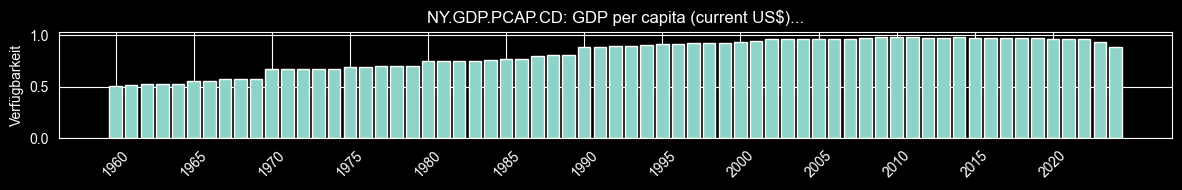

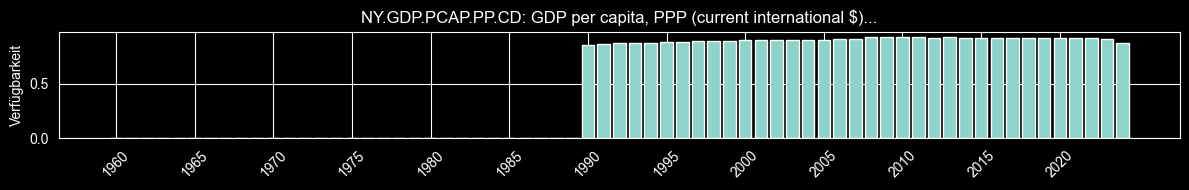

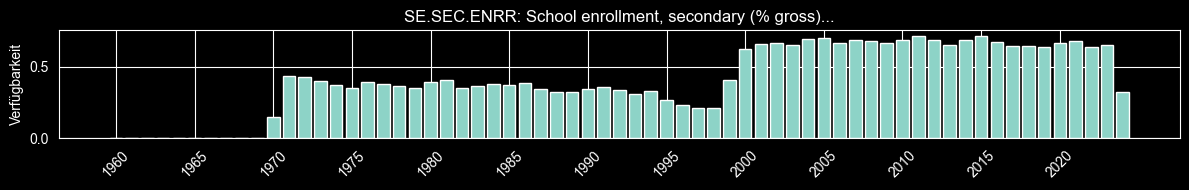

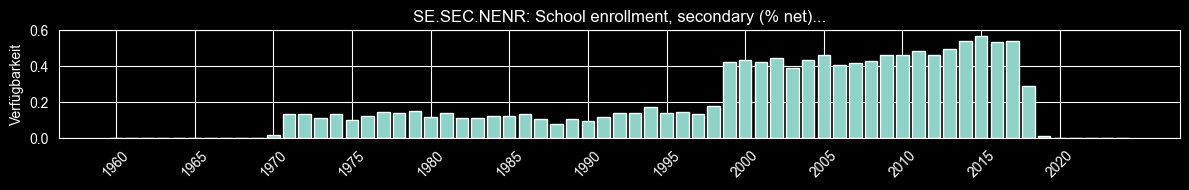

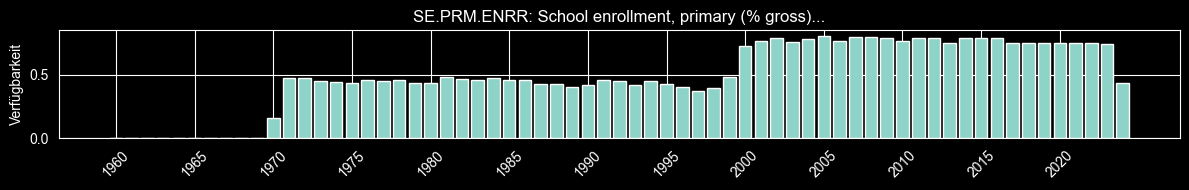

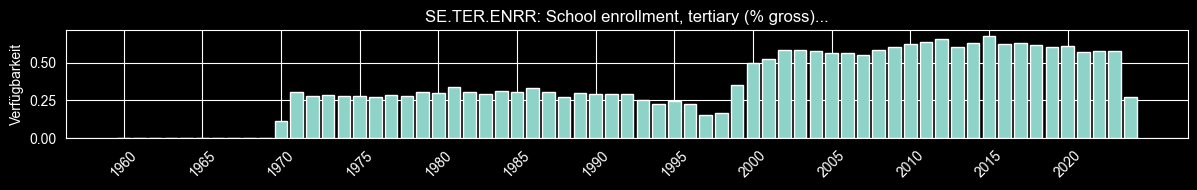

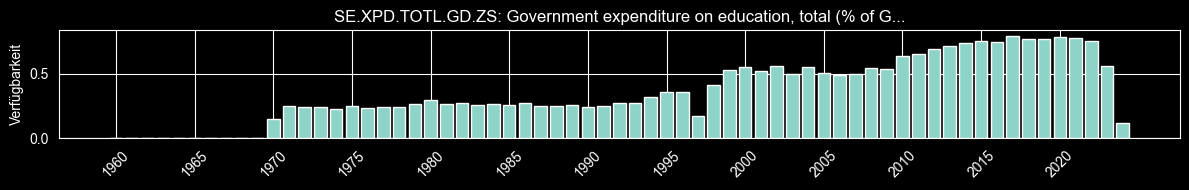

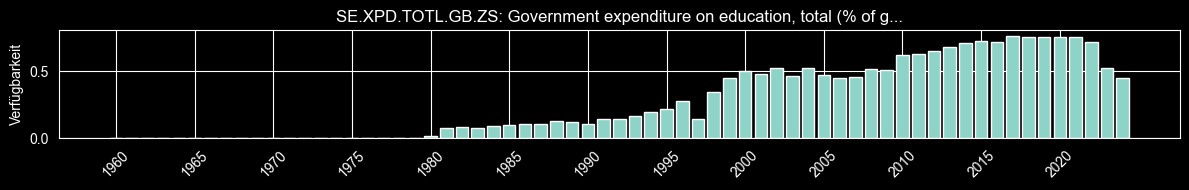

In [12]:
# Jahresspalten
year_cols = [col for col in df_filtered.columns if col.isdigit()]

# Verfügbarkeit pro Jahr und Indikator
for indicator_code in INDICATORS.keys():
    df_ind = df_filtered[df_filtered["Indicator Code"] == indicator_code]
    available = df_ind[year_cols].notna().mean()
    
    plt.figure(figsize=(12, 2))
    plt.bar(available.index, available.values)
    plt.title(f"{indicator_code}: {INDICATORS[indicator_code][:50]}...")
    plt.ylabel("Verfügbarkeit")
    plt.xticks(range(0, len(year_cols), 5), [year_cols[i] for i in range(0, len(year_cols), 5)], rotation=45)
    plt.tight_layout()
    plt.show()

### Zeitraum festlegen

Basierend auf der Verfügbarkeit wählen wir den Zeitraum:

In [13]:
START_YEAR = 1990
END_YEAR = 2023

print(f"Gewählter Zeitraum: {START_YEAR} - {END_YEAR}")

Gewählter Zeitraum: 1990 - 2023


## 4. Transformation ins Long-Format

Für die Analyse transformieren wir die Daten vom Wide- ins Long-Format.

In [14]:
# Wide-Format (aktuell)
print("Wide-Format:")
df_filtered[["Country Name", "Indicator Code", "2020", "2021", "2022"]].head(3)

Wide-Format:


,Country Name,Indicator Code,2020,2021,2022
74658,Afghanistan,NY.GDP.PCAP.CD,510.787063,356.496214,357.261153
74661,Afghanistan,NY.GDP.PCAP.PP.CD,2561.981761,2144.166570,2122.995815
74701,Afghanistan,SE.XPD.TOTL.GD.ZS,NaN,NaN,NaN


In [15]:
# Transformation ins Long-Format
df_long = df_filtered.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Value"
)

# Year als Integer
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")

# Zeitraum filtern
df_long = df_long[(df_long["Year"] >= START_YEAR) & (df_long["Year"] <= END_YEAR)]

# NaN-Werte entfernen
df_long = df_long.dropna(subset=["Value"])

print(f"Long-Format: {len(df_long):,} Zeilen")
df_long.head(10)

Long-Format: 36,298 Zeilen


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
52084,Afghanistan,AFG,"School enrollment, primary (% gross)",SE.PRM.ENRR,1990,30.983040
52085,Afghanistan,AFG,"School enrollment, secondary (% gross)",SE.SEC.ENRR,1990,11.039550
52087,Afghanistan,AFG,"School enrollment, tertiary (% gross)",SE.TER.ENRR,1990,2.215200
52088,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,1990,617.230436
52089,Albania,ALB,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,1990,2655.059901
52096,Algeria,DZA,GDP per capita (current US$),NY.GDP.PCAP.CD,1990,2445.183327
52097,Algeria,DZA,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,1990,7602.187257
52100,Algeria,DZA,"School enrollment, primary (% gross)",SE.PRM.ENRR,1990,96.017372
52101,Algeria,DZA,"School enrollment, secondary (% gross)",SE.SEC.ENRR,1990,60.615879
52103,Algeria,DZA,"School enrollment, tertiary (% gross)",SE.TER.ENRR,1990,10.071050


## 5. Pivotieren für Analyse

Für Korrelationsanalysen brauchen wir die Indikatoren als Spalten:

In [16]:
# Pivot: Eine Zeile pro Land+Jahr, Indikatoren als Spalten
df_pivot = df_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator Code",
    values="Value"
).reset_index()

print(f"Pivot-Format: {df_pivot.shape}")
df_pivot.head()

Pivot-Format: (7137, 11)


Indicator Code,Country Name,Country Code,Year,NY.GDP.PCAP.CD,NY.GDP.PCAP.PP.CD,SE.PRM.ENRR,SE.SEC.ENRR,SE.SEC.NENR,SE.TER.ENRR,SE.XPD.TOTL.GB.ZS,SE.XPD.TOTL.GD.ZS
0,Afghanistan,AFG,1990,NaN,NaN,30.983040,11.039550,NaN,2.2152,NaN,NaN
1,Afghanistan,AFG,1991,NaN,NaN,31.605021,17.183611,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1993,NaN,NaN,33.955250,17.416910,14.51242,NaN,NaN,NaN
3,Afghanistan,AFG,1994,NaN,NaN,44.788841,23.468580,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1995,NaN,NaN,47.661442,23.054520,NaN,NaN,NaN,NaN


## 6. Erste Korrelationsübersicht

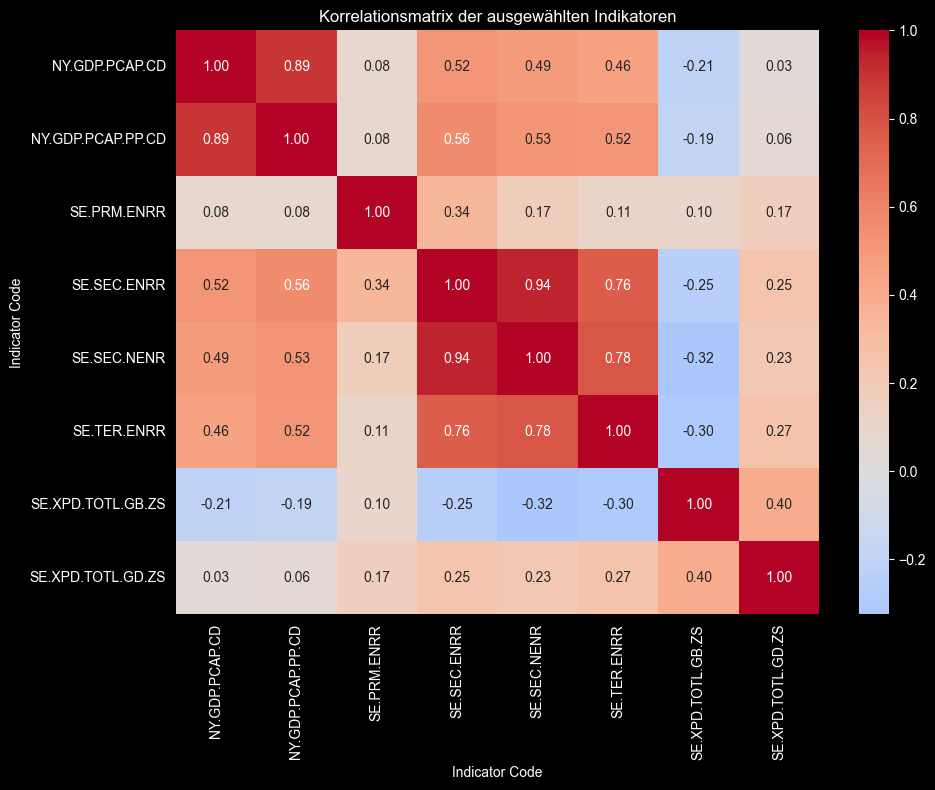

In [17]:
# Korrelationsmatrix der numerischen Spalten
numeric_cols = [col for col in df_pivot.columns if col in INDICATORS.keys()]
corr_matrix = df_pivot[numeric_cols].corr()

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Korrelationsmatrix der ausgewählten Indikatoren")
plt.tight_layout()
plt.show()

## 7. Zusammenfassung

### Entscheidungen für `build_features.py`:

1. **Länder filtern:** Nur Einträge mit `Region` in `WDICountry.csv` (keine Aggregate)
2. **Indikatoren:** Die 8 ausgewählten Indikatoren (siehe `INDICATORS`)
3. **Zeitraum:** 1990-2023
4. **Format:** Long-Format + Pivot-Format speichern
5. **Fehlende Werte:** Zeilen mit NaN entfernen

### Output-Dateien:
- `data/processed/wdi_long.csv` - Long-Format
- `data/processed/wdi_pivot.csv` - Pivot-Format (für Korrelationen)